In [1]:
import seaborn as snb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import RobustScaler  # Changed import
from catboost import CatBoostRegressor

In [2]:
# Read the Stamping data from the Excel file
df = pd.read_excel('Raw_Data_v0.xlsx')

In [3]:
df = df.drop(columns=['Ref#','Heat treatment','Other RM/Rivet/part cost (€/Part)','Gross Weight (g)','Other assembled RM/Rivet/part','Heat Treatment cost (€/Part)'])
df['Raw Material'] = df['Raw Material'].str.title()
df = df.fillna('0')


# Columns to encode
columns_to_encode = ['Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment']
target_column = 'Total cost with amortization (€/part)'

# Mean Encoding
def mean_encode(df, columns, target):
    for col in columns:
        mean_map = df.groupby(col)[target].mean()
        df[col + '_encoded'] = df[col].map(mean_map)
    return df

df = mean_encode(df, columns_to_encode, target_column)

# Drop original categorical columns
df.drop(columns=columns_to_encode, inplace=True)

### Linear Regression

[I 2025-05-12 21:46:22,552] A new study created in memory with name: no-name-4879b1be-22c1-4d9b-9bd7-0901b17180a8
[I 2025-05-12 21:46:22,585] Trial 0 finished with value: 0.08374564604103785 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 0.08374564604103785.
[I 2025-05-12 21:46:22,592] Trial 1 finished with value: 0.08374564604103785 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 0.08374564604103785.


[I 2025-05-12 21:46:22,601] Trial 2 finished with value: 0.14865890082144445 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 0.08374564604103785.
[I 2025-05-12 21:46:22,608] Trial 3 finished with value: 0.14967415539147613 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 0.08374564604103785.
[I 2025-05-12 21:46:22,616] Trial 4 finished with value: 0.14967415539147613 and parameters: {'fit_intercept': False, 'positive': True}. Best is trial 0 with value: 0.08374564604103785.
[I 2025-05-12 21:46:22,622] Trial 5 finished with value: 0.08374564604103785 and parameters: {'fit_intercept': True, 'positive': False}. Best is trial 0 with value: 0.08374564604103785.
[I 2025-05-12 21:46:22,627] Trial 6 finished with value: 0.14865890082144445 and parameters: {'fit_intercept': True, 'positive': True}. Best is trial 0 with value: 0.08374564604103785.
[I 2025-05-12 21:46:22,632] Trial 7 finished with value: 0.0837456460410

Best Params for Linear Regression: {'fit_intercept': True, 'positive': False}
Best RMSE from Optuna: 0.0837

=== Test Set Metrics (Linear Regression) ===
RMSE: 0.0837
MAE:  0.0602
R²:   0.9340

Note: Iterative loss curve plot is not applicable for standard Linear Regression.


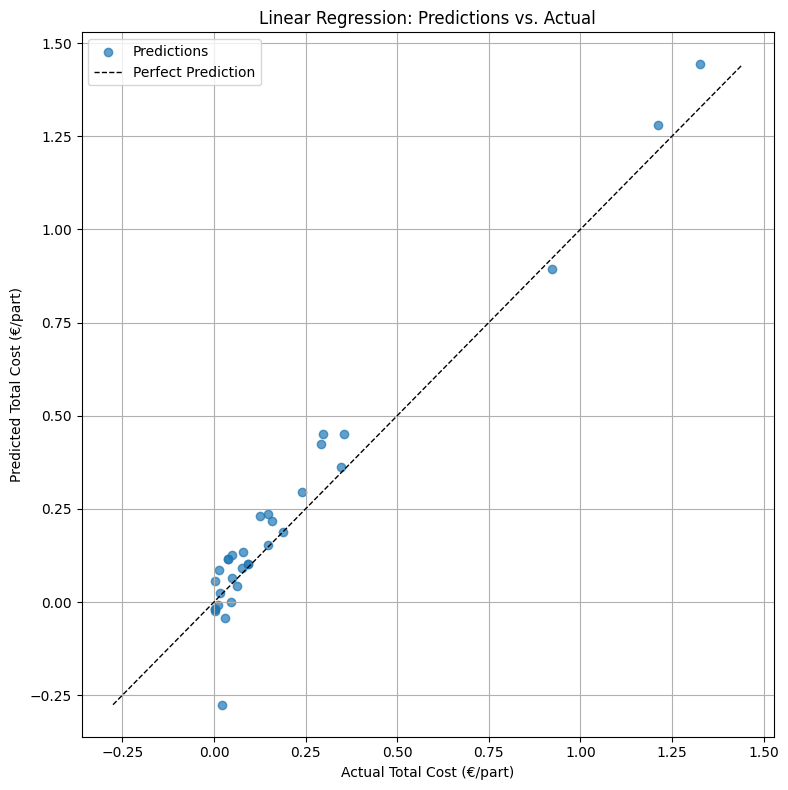

In [6]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import optuna

# --- Load your DataFrame ---
# Make sure your DataFrame 'df' is loaded here AND
# that it has already undergone mean encoding (e.g., 'Production_encoded' exists)
# and original categorical columns (e.g., 'Production') have been dropped.
# For example:
# df = pd.read_csv('/full/path/to/your/preprocessed_data.csv')

# For demonstration, let's create a placeholder df that *mimics* the state
# AFTER mean encoding and dropping original categoricals.
if 'df' not in locals() and 'df' not in globals():
    print("DataFrame 'df' not found. Creating a placeholder DataFrame as if preprocessed.")
    data = {
        'Annual target quantity': np.random.rand(100) * 1000,
        'Raw Material Cost (€/kg)': np.random.rand(100) * 10,
        'Thickness (mm)': np.random.rand(100) * 5,
        'Part Net Weight (g)': np.random.rand(100) * 100,
        'Final Raw Material cost (€/Part)': np.random.rand(100) * 2,
        'Surface Treatment cost (€/Part)': np.random.rand(100) * 1,
        'Production_encoded': np.random.rand(100) * 15, # Example encoded
        'Raw Material_encoded': np.random.rand(100) * 15, # Example encoded
        'Raw Material Designation_encoded': np.random.rand(100) * 15, # Example encoded
        'Surface Treatment_encoded': np.random.rand(100) * 15, # Example encoded
        'Total cost with amortization (€/part)': np.random.rand(100) * 20
    }
    df = pd.DataFrame(data)

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity',
    'Raw Material Cost (€/kg)',
    'Thickness (mm)',
    'Part Net Weight (g)',
    'Final Raw Material cost (€/Part)',
    'Surface Treatment cost (€/Part)'
]

# Original categorical columns (still needed to construct the names of the encoded ones)
original_categorical_features = [
    'Production',
    'Raw Material',
    'Raw Material Designation',
    'Surface Treatment'
]
target_column = 'Total cost with amortization (€/part)'

# --- Prepare DataFrame ---

# Assuming mean encoding (creating columns like 'Production_encoded')
# and dropping of original categorical columns has already been done on 'df'
# as per the context provided from the CatBoost script.

# The 'original_categorical_features' list is still useful to define 'encoded_categorical_features'

# Create list of new encoded feature names
encoded_categorical_features = [col + '_encoded' for col in original_categorical_features]

# Scaling numerical features
# Ensure all features_to_scale exist in df
scaler = RobustScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# Selected features for the model
# Ensure all selected_features exist in df
selected_features = features_to_scale + encoded_categorical_features
X = df[selected_features].copy()
y = df[target_column].copy()

# Handle any potential NaNs in X
X.fillna(X.mean(), inplace=True)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Compute Sample Weights for Imbalance ---
y_bins = pd.qcut(y_train, q=10, duplicates='drop', retbins=False)
bin_counts = y_bins.value_counts()
bin_weight_map = {b: 1.0 / count for b, count in bin_counts.items()}
sample_weights = y_bins.map(bin_weight_map)
sample_weights.fillna(1.0, inplace=True)
sample_weights *= len(y_train) / sample_weights.sum()

# --- Bayesian Hyperparameter Search with Optuna for Linear Regression ---
def objective(trial):
    params = {
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'positive': trial.suggest_categorical('positive', [True, False])
    }
    model = LinearRegression(**params)
    model.fit(
        X_train, y_train,
        sample_weight=sample_weights
    )
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f"Best Params for Linear Regression: {best_params}")
print(f"Best RMSE from Optuna: {study.best_value:.4f}")

# --- Train Final Model with Best Params ---
final_model = LinearRegression(**best_params)
final_model.fit(
    X_train, y_train,
    sample_weight=sample_weights
)

# --- Predictions on Test Set ---
y_pred = final_model.predict(X_test)

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n=== Test Set Metrics (Linear Regression) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot: Loss Curve ---
print("\nNote: Iterative loss curve plot is not applicable for standard Linear Regression.")

# --- Plot: Predictions vs. Actual ---
plt.figure(figsize=(8, 8))
plt.scatter(
    y_test,
    y_pred,
    alpha=0.7,
    label='Predictions'
)
lims = [
    min(y_test.min(), y_pred.min()),
    max(y_test.max(), y_pred.max())
]
plt.plot(lims, lims, 'k--', lw=1, label='Perfect Prediction')
plt.xlabel('Actual Total Cost (€/part)')
plt.ylabel('Predicted Total Cost (€/part)')
plt.title('Linear Regression: Predictions vs. Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


### Ridge

[I 2025-05-12 21:51:38,924] A new study created in memory with name: no-name-7f5a8b16-d11d-4eea-bfd6-a23b7fe796d3
C:\Users\adria\AppData\Local\Temp\ipykernel_20184\3661391681.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 1e2),
[I 2025-05-12 21:51:38,939] Trial 0 finished with value: 0.08568601542100782 and parameters: {'alpha': 33.139460280323156, 'fit_intercept': True, 'solver': 'lsqr'}. Best is trial 0 with value: 0.08568601542100782.
C:\Users\adria\AppData\Local\Temp\ipykernel_20184\3661391681.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-3, 1e2),
C:\Users\adr

Best Params for Ridge Regression: {'alpha': 9.828282133989058, 'fit_intercept': False, 'solver': 'svd'}
Best RMSE from Optuna: 0.0625

=== Test Set Metrics (Ridge Regression) ===
RMSE: 0.0625
MAE:  0.0450
R²:   0.9632

Note: Iterative loss curve (like in CatBoost) is not applicable for Ridge Regression.


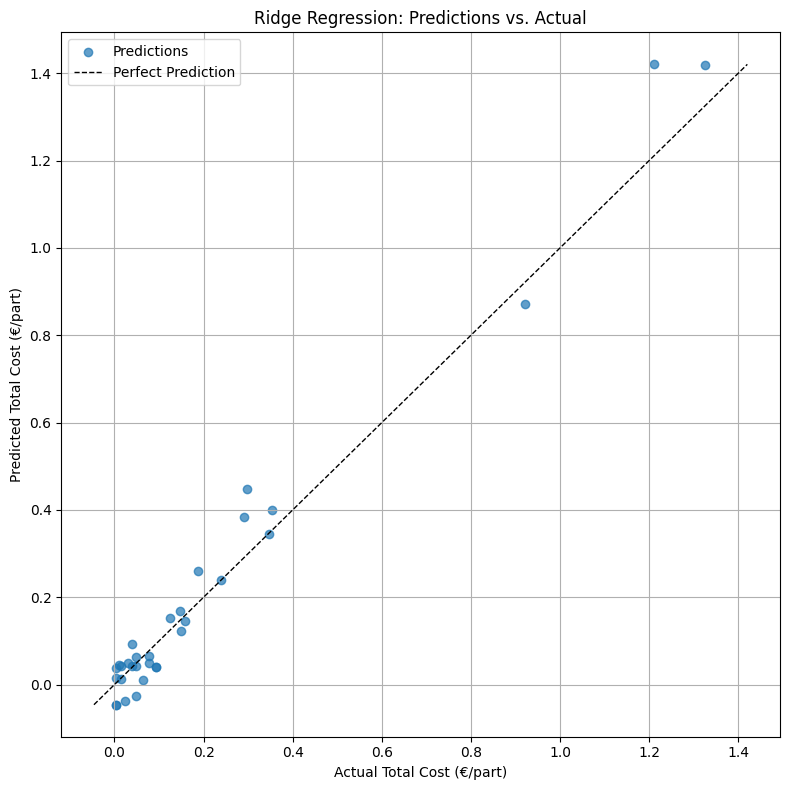

In [9]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import optuna

# --- Load your DataFrame ---
# Ensure 'df' is loaded and preprocessed with mean-encoded features
# and original categorical columns dropped.
# Example placeholder:
if 'df' not in locals() and 'df' not in globals():
    print("DataFrame 'df' not found. Creating a placeholder.")
    data = {
        'Annual target quantity': np.random.rand(100) * 1000,
        'Raw Material Cost (€/kg)': np.random.rand(100) * 10,
        'Thickness (mm)': np.random.rand(100) * 5,
        'Part Net Weight (g)': np.random.rand(100) * 100,
        'Final Raw Material cost (€/Part)': np.random.rand(100) * 2,
        'Surface Treatment cost (€/Part)': np.random.rand(100) * 1,
        'Production_encoded': np.random.rand(100) * 15,
        'Raw Material_encoded': np.random.rand(100) * 15,
        'Raw Material Designation_encoded': np.random.rand(100) * 15,
        'Surface Treatment_encoded': np.random.rand(100) * 15,
        'Total cost with amortization (€/part)': np.random.rand(100) * 20
    }
    df = pd.DataFrame(data)

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)'
]
original_categorical_features = [
    'Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment'
]
target_column = 'Total cost with amortization (€/part)'

# --- Prepare DataFrame ---
encoded_categorical_features = [col + '_encoded' for col in original_categorical_features]

scaler = RobustScaler()
existing_features_to_scale = [col for col in features_to_scale if col in df.columns]
if existing_features_to_scale:
    df[existing_features_to_scale] = scaler.fit_transform(df[existing_features_to_scale])

selected_features_list = existing_features_to_scale + encoded_categorical_features
final_selected_features = [col for col in selected_features_list if col in df.columns]

if not final_selected_features:
    raise ValueError("Error: No features selected for modeling are present in the DataFrame.")

X = df[final_selected_features].copy()
y = df[target_column].copy()
X.fillna(X.mean(), inplace=True)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Compute Sample Weights ---
y_bins = pd.qcut(y_train, q=10, duplicates='drop', retbins=False)
bin_counts = y_bins.value_counts()
bin_weight_map = {b: 1.0 / count for b, count in bin_counts.items()}
sample_weights = y_bins.map(bin_weight_map)
sample_weights.fillna(1.0, inplace=True)
sample_weights *= len(y_train) / sample_weights.sum()

# --- Optuna Hyperparameter Search ---
def objective(trial):
    params = {
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 1e2),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    }
    model = Ridge(**params, random_state=42)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=20)

best_params = study.best_params
print(f"Best Params for Ridge Regression: {best_params}")
print(f"Best RMSE from Optuna: {study.best_value:.4f}")

# --- Train Final Model ---
final_model = Ridge(**best_params, random_state=42)
final_model.fit(X_train, y_train, sample_weight=sample_weights)

# --- Predictions ---
y_pred = final_model.predict(X_test)

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n=== Test Set Metrics (Ridge Regression) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot: Iterative Loss Curve ---
# Ridge Regression (like standard Linear Regression) is typically solved directly,
# not through an iterative process that produces per-iteration loss values
# like CatBoost's `get_evals_result()`. Thus, a CatBoost-style iterative loss curve is not applicable here.
print("\nNote: Iterative loss curve (like in CatBoost) is not applicable for Ridge Regression.")

# --- Plot: Predictions vs. Actual ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1, label='Perfect Prediction')
plt.xlabel('Actual Total Cost (€/part)')
plt.ylabel('Predicted Total Cost (€/part)')
plt.title('Ridge Regression: Predictions vs. Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Decision Tree


[I 2025-05-12 21:55:04,772] A new study created in memory with name: no-name-7eb67c4c-68ba-4d5b-9c76-b3d1143093b5
[I 2025-05-12 21:55:04,783] Trial 0 finished with value: 0.3455851256244141 and parameters: {'criterion': 'friedman_mse', 'max_depth': 32, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3455851256244141.
[I 2025-05-12 21:55:04,792] Trial 1 finished with value: 0.4267500995064032 and parameters: {'criterion': 'friedman_mse', 'max_depth': 2, 'min_samples_split': 11, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.3455851256244141.


[I 2025-05-12 21:55:04,799] Trial 2 finished with value: 0.2618269034408787 and parameters: {'criterion': 'poisson', 'max_depth': 24, 'min_samples_split': 17, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 2 with value: 0.2618269034408787.
[I 2025-05-12 21:55:04,809] Trial 3 finished with value: 0.17125775195543716 and parameters: {'criterion': 'absolute_error', 'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 3 with value: 0.17125775195543716.
[I 2025-05-12 21:55:04,819] Trial 4 finished with value: 0.2547125622497308 and parameters: {'criterion': 'squared_error', 'max_depth': 13, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2'}. Best is trial 3 with value: 0.17125775195543716.
[I 2025-05-12 21:55:04,830] Trial 5 finished with value: 0.2511337347570688 and parameters: {'criterion': 'friedman_mse', 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 9, 'max_features': None}. Best is trial

Best Params for Decision Tree Regressor: {'criterion': 'poisson', 'max_depth': 14, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'sqrt'}
Best RMSE from Optuna: 0.1068

=== Test Set Metrics (Decision Tree Regressor) ===
RMSE: 0.1068
MAE:  0.0577
R²:   0.8927

Generating Learning Curves for Decision Tree Regressor...


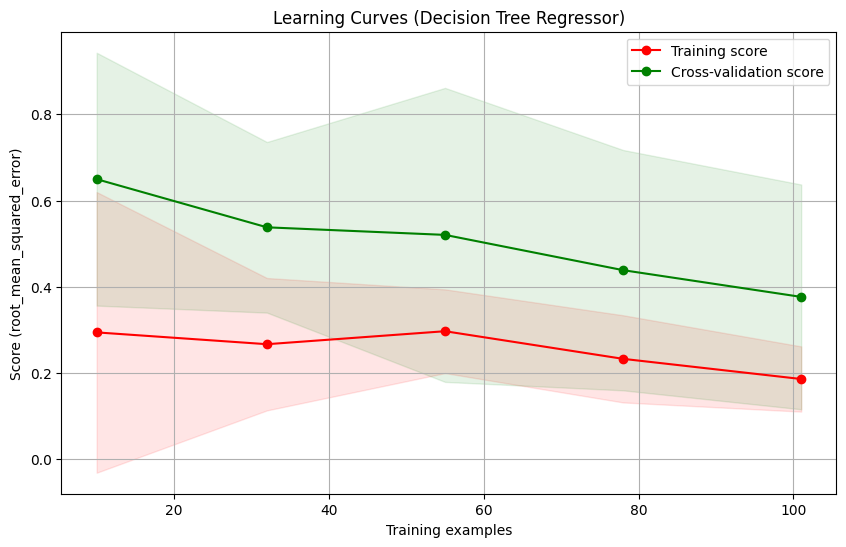

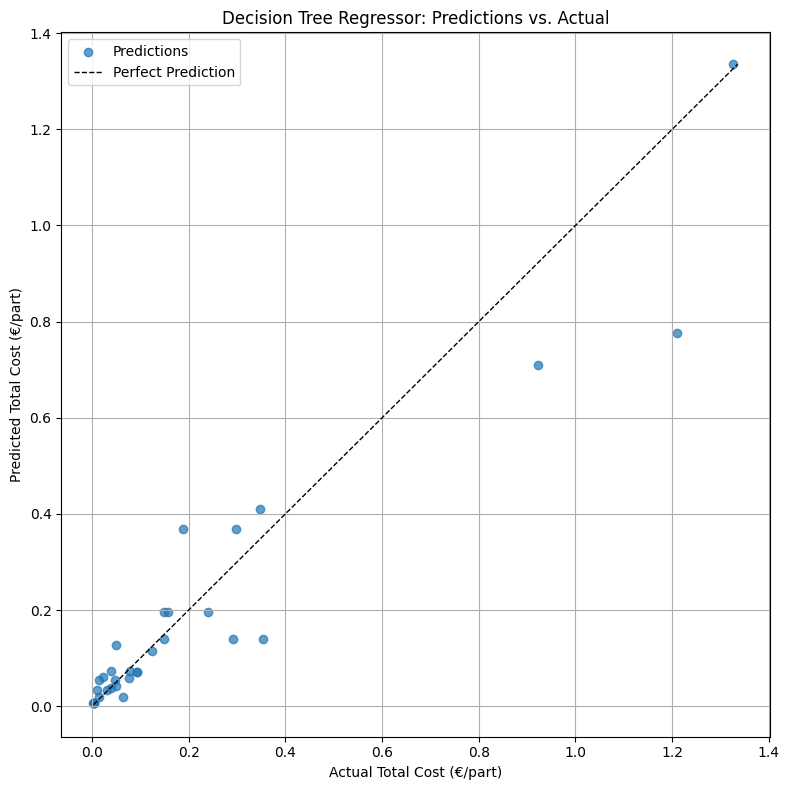

In [13]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import optuna

# --- Load your DataFrame ---
# Ensure 'df' is loaded and preprocessed with mean-encoded features
# and original categorical columns dropped.
# Example placeholder:
if 'df' not in locals() and 'df' not in globals():
    print("DataFrame 'df' not found. Creating a placeholder.")
    data = {
        'Annual target quantity': np.random.rand(100) * 1000,
        'Raw Material Cost (€/kg)': np.random.rand(100) * 10,
        'Thickness (mm)': np.random.rand(100) * 5,
        'Part Net Weight (g)': np.random.rand(100) * 100,
        'Final Raw Material cost (€/Part)': np.random.rand(100) * 2,
        'Surface Treatment cost (€/Part)': np.random.rand(100) * 1,
        'Production_encoded': np.random.rand(100) * 15,
        'Raw Material_encoded': np.random.rand(100) * 15,
        'Raw Material Designation_encoded': np.random.rand(100) * 15,
        'Surface Treatment_encoded': np.random.rand(100) * 15,
        'Total cost with amortization (€/part)': np.random.rand(100) * 20
    }
    df = pd.DataFrame(data)

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)'
]
original_categorical_features = [
    'Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment'
]
target_column = 'Total cost with amortization (€/part)'

# --- Prepare DataFrame ---
encoded_categorical_features = [col + '_encoded' for col in original_categorical_features]

scaler = RobustScaler()
existing_features_to_scale = [col for col in features_to_scale if col in df.columns]
if existing_features_to_scale:
    df[existing_features_to_scale] = scaler.fit_transform(df[existing_features_to_scale])

selected_features_list = existing_features_to_scale + encoded_categorical_features
final_selected_features = [col for col in selected_features_list if col in df.columns]

if not final_selected_features:
    raise ValueError("Error: No features selected for modeling are present in the DataFrame.")

X = df[final_selected_features].copy()
y = df[target_column].copy()
X.fillna(X.mean(), inplace=True)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Compute Sample Weights ---
y_bins = pd.qcut(y_train, q=10, duplicates='drop', retbins=False)
bin_counts = y_bins.value_counts()
bin_weight_map = {b: 1.0 / count for b, count in bin_counts.items()}
sample_weights = y_bins.map(bin_weight_map)
sample_weights.fillna(1.0, inplace=True)
sample_weights *= len(y_train) / sample_weights.sum()

# --- Optuna Hyperparameter Search ---
def objective(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2'])
    }
    model = DecisionTreeRegressor(**params, random_state=42)
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Params for Decision Tree Regressor: {best_params}")
print(f"Best RMSE from Optuna: {study.best_value:.4f}")

# --- Train Final Model ---
final_model = DecisionTreeRegressor(**best_params, random_state=42)
final_model.fit(X_train, y_train, sample_weight=sample_weights)

# --- Predictions ---
y_pred = final_model.predict(X_test)

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n=== Test Set Metrics (Decision Tree Regressor) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot: Learning Curves ---
def plot_learning_curve(estimator, title, X_plot, y_plot, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_root_mean_squared_error'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(f"Score ({scoring.replace('neg_', '')})")

    train_sizes_abs, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_plot, y_plot, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring=scoring,
                       return_times=True)
    
    # Adjust scores if using a 'neg_' metric for plotting
    train_scores_mean = -np.mean(train_scores, axis=1) if scoring.startswith('neg_') else np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1) if scoring.startswith('neg_') else np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")
    return plt

print("\nGenerating Learning Curves for Decision Tree Regressor...")
cv_strategy = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
plot_learning_curve(final_model, "Learning Curves (Decision Tree Regressor)", X_train, y_train, cv=cv_strategy, n_jobs=-1, scoring='neg_root_mean_squared_error')
plt.show()

# --- Plot: Predictions vs. Actual ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1, label='Perfect Prediction')
plt.xlabel('Actual Total Cost (€/part)')
plt.ylabel('Predicted Total Cost (€/part)')
plt.title('Decision Tree Regressor: Predictions vs. Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Random Forest

[I 2025-05-12 21:57:15,330] A new study created in memory with name: no-name-4e80a1c2-a520-4054-a454-99995df18e7d


[I 2025-05-12 21:57:15,701] Trial 0 finished with value: 0.24159950635758976 and parameters: {'n_estimators': 283, 'max_depth': 5, 'min_samples_split': 16, 'min_samples_leaf': 15, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.24159950635758976.
[I 2025-05-12 21:57:15,910] Trial 1 finished with value: 0.19864291598318168 and parameters: {'n_estimators': 166, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.19864291598318168.
[I 2025-05-12 21:57:16,177] Trial 2 finished with value: 0.24845278027423526 and parameters: {'n_estimators': 210, 'max_depth': 4, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 1 with value: 0.19864291598318168.
[I 2025-05-12 21:57:16,270] Trial 3 finished with value: 0.11465339103327313 and parameters: {'n_estimators': 67, 'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max

Best Params for Random Forest Regressor: {'n_estimators': 238, 'max_depth': 26, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True}
Best RMSE from Optuna: 0.0725

=== Test Set Metrics (Random Forest Regressor) ===
RMSE: 0.0725
MAE:  0.0447
R²:   0.9505

Generating Learning Curves for Random Forest Regressor...


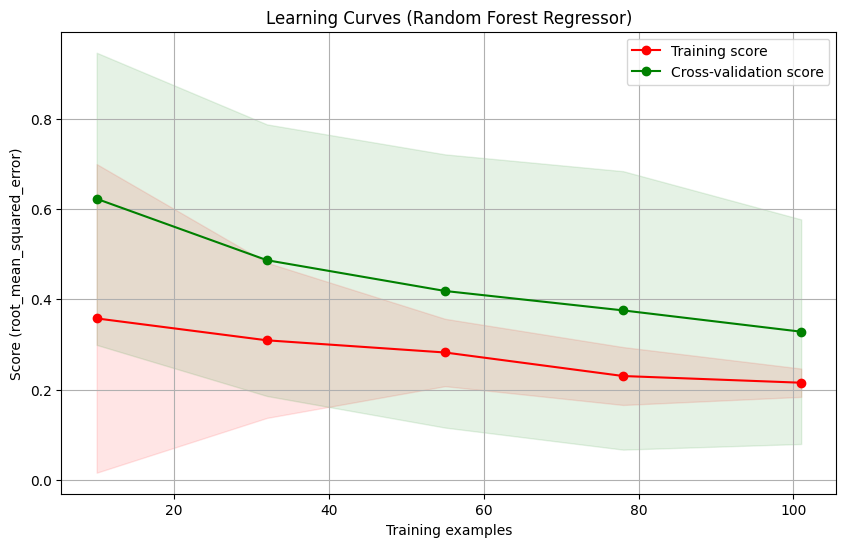

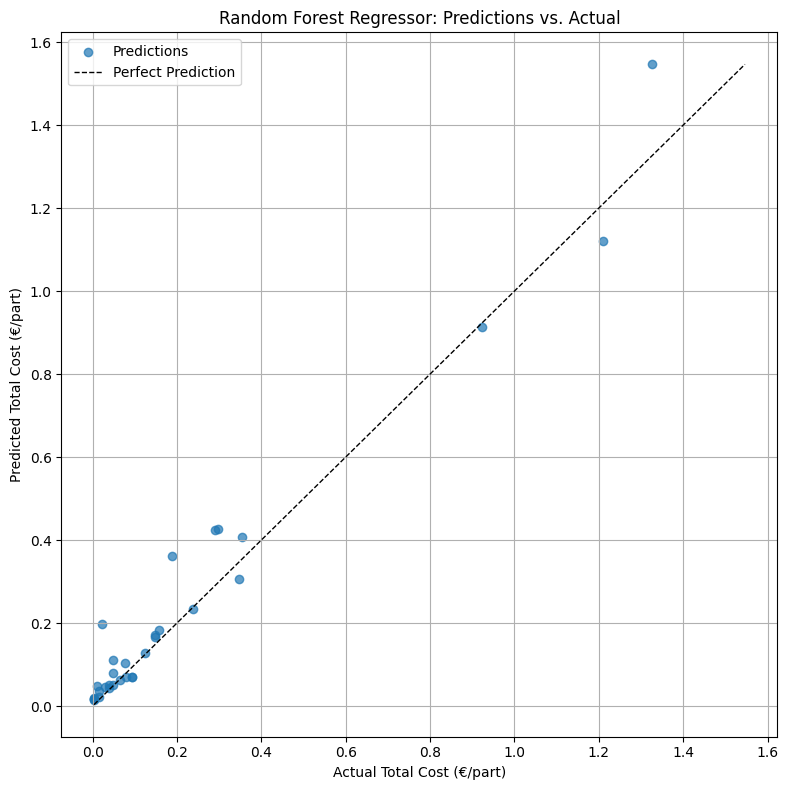

In [15]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor # Changed to RandomForestRegressor
import matplotlib.pyplot as plt
import optuna

# --- Load your DataFrame ---
# Ensure 'df' is loaded and preprocessed with mean-encoded features
# and original categorical columns dropped.
# Example placeholder:
if 'df' not in locals() and 'df' not in globals():
    print("DataFrame 'df' not found. Creating a placeholder.")
    data = {
        'Annual target quantity': np.random.rand(100) * 1000,
        'Raw Material Cost (€/kg)': np.random.rand(100) * 10,
        'Thickness (mm)': np.random.rand(100) * 5,
        'Part Net Weight (g)': np.random.rand(100) * 100,
        'Final Raw Material cost (€/Part)': np.random.rand(100) * 2,
        'Surface Treatment cost (€/Part)': np.random.rand(100) * 1,
        'Production_encoded': np.random.rand(100) * 15,
        'Raw Material_encoded': np.random.rand(100) * 15,
        'Raw Material Designation_encoded': np.random.rand(100) * 15,
        'Surface Treatment_encoded': np.random.rand(100) * 15,
        'Total cost with amortization (€/part)': np.random.rand(100) * 20
    }
    df = pd.DataFrame(data)

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)'
]
original_categorical_features = [
    'Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment'
]
target_column = 'Total cost with amortization (€/part)'

# --- Prepare DataFrame ---
encoded_categorical_features = [col + '_encoded' for col in original_categorical_features]

scaler = RobustScaler()
existing_features_to_scale = [col for col in features_to_scale if col in df.columns]
if existing_features_to_scale:
    df[existing_features_to_scale] = scaler.fit_transform(df[existing_features_to_scale])

selected_features_list = existing_features_to_scale + encoded_categorical_features
final_selected_features = [col for col in selected_features_list if col in df.columns]

if not final_selected_features:
    raise ValueError("Error: No features selected for modeling are present in the DataFrame.")

X = df[final_selected_features].copy()
y = df[target_column].copy()
X.fillna(X.mean(), inplace=True)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Compute Sample Weights ---
y_bins = pd.qcut(y_train, q=10, duplicates='drop', retbins=False)
bin_counts = y_bins.value_counts()
bin_weight_map = {b: 1.0 / count for b, count in bin_counts.items()}
sample_weights = y_bins.map(bin_weight_map)
sample_weights.fillna(1.0, inplace=True)
sample_weights *= len(y_train) / sample_weights.sum()

# --- Optuna Hyperparameter Search ---
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),       # Number of trees in the forest
        'max_depth': trial.suggest_int('max_depth', 3, 32, log=True),      # Max depth of each tree
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),# Min samples to split a node
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),   # Min samples in a leaf node
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]), # Number of features for best split
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]) # Whether bootstrap samples are used
    }
    # RandomForestRegressor in scikit-learn versions < 1.2 does not directly accept sample_weight in fit
    # if bootstrap=True (default). If you need sample_weight with older versions and bootstrap,
    # you might need a workaround or set bootstrap=False.
    # For scikit-learn >= 1.2, sample_weight is supported with bootstrap=True.
    # We'll assume a modern enough version or that the user will handle it if issues arise.
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1) # n_jobs=-1 for parallel processing
    model.fit(X_train, y_train, sample_weight=sample_weights)
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50) # Random Forests can also benefit from more trials

best_params = study.best_params
print(f"Best Params for Random Forest Regressor: {best_params}")
print(f"Best RMSE from Optuna: {study.best_value:.4f}")

# --- Train Final Model ---
final_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train, sample_weight=sample_weights)

# --- Predictions ---
y_pred = final_model.predict(X_test)

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n=== Test Set Metrics (Random Forest Regressor) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot: Learning Curves ---
def plot_learning_curve(estimator, title, X_plot, y_plot, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_root_mean_squared_error'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(f"Score ({scoring.replace('neg_', '')})")

    train_sizes_abs, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_plot, y_plot, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring=scoring,
                       return_times=True)
    
    train_scores_mean = -np.mean(train_scores, axis=1) if scoring.startswith('neg_') else np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1) if scoring.startswith('neg_') else np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")
    return plt

print("\nGenerating Learning Curves for Random Forest Regressor...")
cv_strategy = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42) # Using 10 splits for learning curve
# For Random Forest, learning curves can take longer, so you might reduce n_splits or train_sizes for quicker checks
plot_learning_curve(final_model, "Learning Curves (Random Forest Regressor)", X_train, y_train, cv=cv_strategy, n_jobs=-1, scoring='neg_root_mean_squared_error')
plt.show()

# --- Plot: Predictions vs. Actual ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1, label='Perfect Prediction')
plt.xlabel('Actual Total Cost (€/part)')
plt.ylabel('Predicted Total Cost (€/part)')
plt.title('Random Forest Regressor: Predictions vs. Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### SVR

[I 2025-05-12 21:59:01,284] A new study created in memory with name: no-name-66881d67-9b20-4647-8f8f-01249eefdd6f
C:\Users\adria\AppData\Local\Temp\ipykernel_20184\1519698641.py:78: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-1, 1e3),             # Regularization parameter
C:\Users\adria\AppData\Local\Temp\ipykernel_20184\1519698641.py:79: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'epsilon': trial.suggest_loguniform('epsilon', 1e-2, 1.0), # Epsilon in the epsilon-SVR model
[I 2025-05-12 21:59:01,297] Trial 0 finished with value: 681.6195077984187 and parameters: {'kernel': 'sigmoid', 'C': 46.11966970920072, 'epsilon': 0.107296

Best Params for SVR: {'kernel': 'linear', 'C': 0.37814502419239254, 'epsilon': 0.010110592596988956}
Best RMSE from Optuna: 0.0353

=== Test Set Metrics (SVR) ===
RMSE: 0.0353
MAE:  0.0265
R²:   0.9883

Generating Learning Curves for SVR...


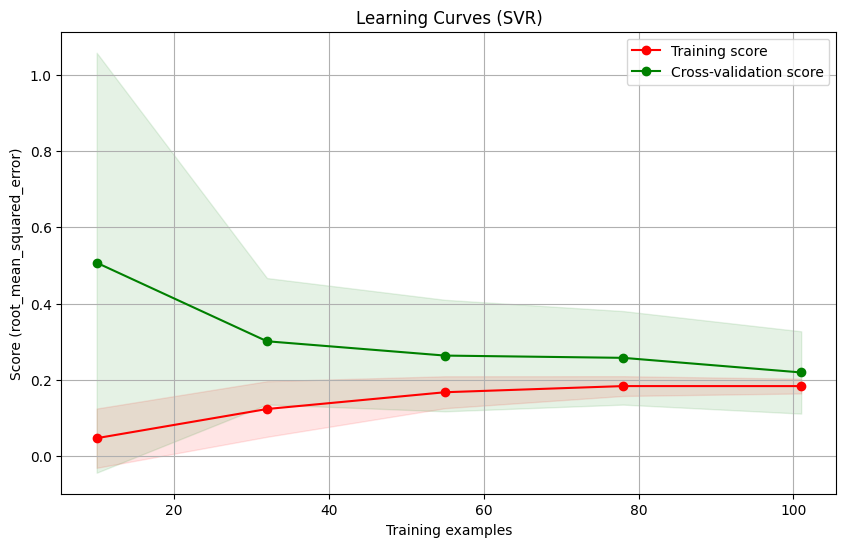

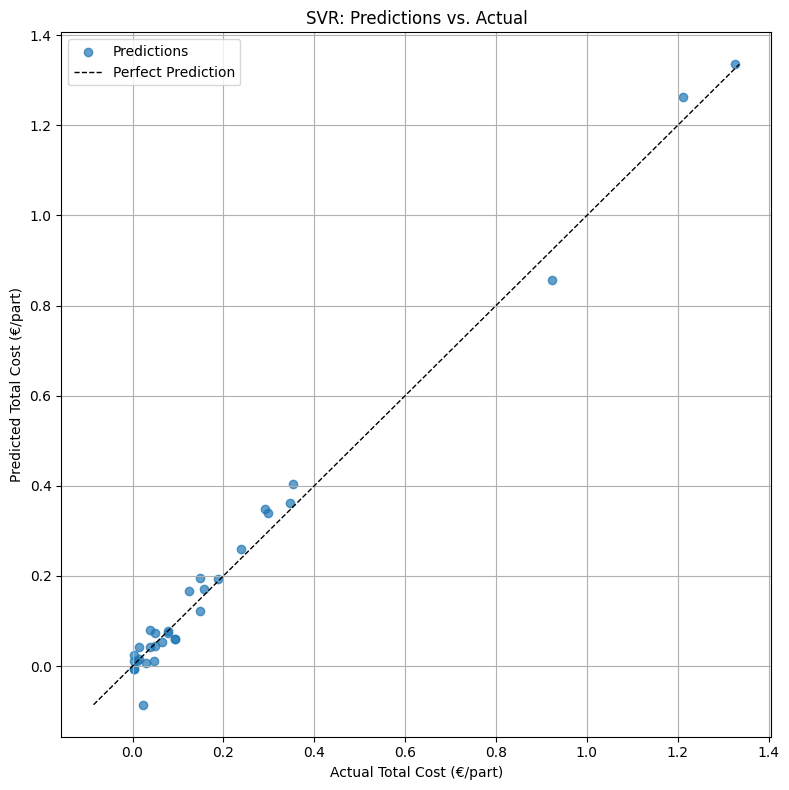

In [17]:
# --- Imports ---
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit # Keep these
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR # Changed to SVR
import matplotlib.pyplot as plt
import optuna

# --- Load your DataFrame ---
# Ensure 'df' is loaded and preprocessed with mean-encoded features
# and original categorical columns dropped.
# Example placeholder:
if 'df' not in locals() and 'df' not in globals():
    print("DataFrame 'df' not found. Creating a placeholder.")
    data = {
        'Annual target quantity': np.random.rand(100) * 1000,
        'Raw Material Cost (€/kg)': np.random.rand(100) * 10,
        'Thickness (mm)': np.random.rand(100) * 5,
        'Part Net Weight (g)': np.random.rand(100) * 100,
        'Final Raw Material cost (€/Part)': np.random.rand(100) * 2,
        'Surface Treatment cost (€/Part)': np.random.rand(100) * 1,
        'Production_encoded': np.random.rand(100) * 15,
        'Raw Material_encoded': np.random.rand(100) * 15,
        'Raw Material Designation_encoded': np.random.rand(100) * 15,
        'Surface Treatment_encoded': np.random.rand(100) * 15,
        'Total cost with amortization (€/part)': np.random.rand(100) * 20
    }
    df = pd.DataFrame(data)

# --- Feature Lists ---
features_to_scale = [
    'Annual target quantity', 'Raw Material Cost (€/kg)', 'Thickness (mm)',
    'Part Net Weight (g)', 'Final Raw Material cost (€/Part)', 'Surface Treatment cost (€/Part)'
]
original_categorical_features = [
    'Production', 'Raw Material', 'Raw Material Designation', 'Surface Treatment'
]
target_column = 'Total cost with amortization (€/part)'

# --- Prepare DataFrame ---
encoded_categorical_features = [col + '_encoded' for col in original_categorical_features]

scaler = RobustScaler()
existing_features_to_scale = [col for col in features_to_scale if col in df.columns]
if existing_features_to_scale:
    df[existing_features_to_scale] = scaler.fit_transform(df[existing_features_to_scale])

selected_features_list = existing_features_to_scale + encoded_categorical_features
final_selected_features = [col for col in selected_features_list if col in df.columns]

if not final_selected_features:
    raise ValueError("Error: No features selected for modeling are present in the DataFrame.")

X = df[final_selected_features].copy()
y = df[target_column].copy()
X.fillna(X.mean(), inplace=True)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Compute Sample Weights ---
# Note: SVR does not directly use sample_weight in its fit method.
# These weights are computed but won't be passed to SVR's fit.
y_bins = pd.qcut(y_train, q=10, duplicates='drop', retbins=False)
bin_counts = y_bins.value_counts()
bin_weight_map = {b: 1.0 / count for b, count in bin_counts.items()}
sample_weights = y_bins.map(bin_weight_map)
sample_weights.fillna(1.0, inplace=True)
sample_weights *= len(y_train) / sample_weights.sum()

# --- Optuna Hyperparameter Search ---
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    params = {
        'kernel': kernel,
        'C': trial.suggest_loguniform('C', 1e-1, 1e3),             # Regularization parameter
        'epsilon': trial.suggest_loguniform('epsilon', 1e-2, 1.0), # Epsilon in the epsilon-SVR model
    }
    if kernel in ['poly', 'rbf', 'sigmoid']:
        params['gamma'] = trial.suggest_categorical('gamma', ['scale', 'auto']) # Kernel coefficient
        # params['gamma'] = trial.suggest_loguniform('gamma', 1e-4, 1e-1) # Alternative for more fine-grained gamma
    if kernel == 'poly':
        params['degree'] = trial.suggest_int('degree', 2, 5)          # Degree for poly kernel

    model = SVR(**params)
    # SVR does not accept sample_weight directly in fit method
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50) # SVR can be sensitive to hyperparameters

best_params = study.best_params
print(f"Best Params for SVR: {best_params}")
print(f"Best RMSE from Optuna: {study.best_value:.4f}")

# --- Train Final Model ---
final_model = SVR(**best_params)
# SVR does not accept sample_weight directly in fit method
final_model.fit(X_train, y_train)

# --- Predictions ---
y_pred = final_model.predict(X_test)

# --- Evaluation Metrics ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\n=== Test Set Metrics (SVR) ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

# --- Plot: Learning Curves ---
def plot_learning_curve(estimator, title, X_plot, y_plot, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), scoring='neg_root_mean_squared_error'):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(10, 6))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(f"Score ({scoring.replace('neg_', '')})")

    train_sizes_abs, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X_plot, y_plot, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       scoring=scoring,
                       return_times=True)
    
    train_scores_mean = -np.mean(train_scores, axis=1) if scoring.startswith('neg_') else np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1) if scoring.startswith('neg_') else np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    axes.grid()
    axes.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1, color="r")
    axes.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
    axes.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")
    return plt

print("\nGenerating Learning Curves for SVR...")
cv_strategy = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
# For SVR, especially with non-linear kernels, learning curves can be very time-consuming.
# You might want to reduce n_splits or train_sizes for quicker initial checks.
plot_learning_curve(final_model, "Learning Curves (SVR)", X_train, y_train, cv=cv_strategy, n_jobs=-1, scoring='neg_root_mean_squared_error')
plt.show()

# --- Plot: Predictions vs. Actual ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, label='Predictions')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'k--', lw=1, label='Perfect Prediction')
plt.xlabel('Actual Total Cost (€/part)')
plt.ylabel('Predicted Total Cost (€/part)')
plt.title('SVR: Predictions vs. Actual')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
